# VizDoom DeadlyCorridor


- Curriculum Learning
- Reward Shaping



All credits to Nicholas Renotte\
Code reproduced only for learning purposes

---

# 1. Getting VizDoom

In [ ]:
# Cloning repository
#!mkdir github
#!cd github & git clone https://github.com/mwydmuch/ViZDoom

In [1]:
import random
import time
import numpy as np
import os

import matplotlib.pyplot as plt

from vizdoom import *

In [2]:
# Setup Game
game = DoomGame()
game.load_config('github/VizDoom/scenarios/deadly_corridor-s1.cfg')
game.init()

In [3]:
# Set of all actions
actions = np.identity(7, dtype=np.uint8)
actions

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [4]:
# Game with random actions
episodes = 2

for episode in range(episodes):
    game.new_episode()
    
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables
        reward = game.make_action(random.choice(actions), 4) # 4 = skipping 4 frames each iteration
        print("reward:", reward)
        time.sleep(0.02)
        
    print("Result:", game.get_total_reward())
    time.sleep(2)
    
game.close()

reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: -6.712554931640625
reward: -9.206634521484375
reward: 6.712310791015625
reward: 10.308486938476562
reward: 14.850265502929688
reward: 15.797622680664062
reward: 11.840408325195312
reward: 7.9864501953125
reward: 5.3868408203125
reward: -2.549591064453125
reward: -1.0699615478515625
reward: -0.1698150634765625
reward: 7.004913330078125
reward: 7.8506011962890625
reward: 4.663909912109375
reward: 2.77069091796875
reward: 1.7738494873046875
reward: 1.1963653564453125
reward: 7.5174713134765625
reward: 8.594512939453125
reward: 5.7970123291015625
reward: 3.9100799560546875
reward: -3.8280029296875
reward: -5.977325439453125
reward: -5.015106201171875
reward: -6.0310821533203125
reward: -6.0258331298828125
reward: -4.0646514892578125
reward: -5.3939208984375
reward: -7.6832427978515625
reward: 0.157684326171875
reward: 0.567840576171875
reward: -3.55224609375
reward: -3.7181243896484375
reward: -2.5080108642578125
reward: -7.8569946289

# 2. Converting Game To Gym Environment

In [5]:
from gym import Env
from gym.spaces import Discrete, Box
import cv2

In [6]:
class VizDoomGym(Env):
    """ Doom game class """
    
    def __init__(self, render=False, config='github/VizDoom/scenarios/deadly_corridor-s1.cfg'):
        """ Inicializing game """
        
        # Inherit from Env
        super().__init__()
        
        # Setup the game
        self.game = DoomGame()
        self.game.load_config(config)
        
        # Render frame logic
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
            
        self.game.init()
        
        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(80,160,1), dtype=np.uint8)
        self.action_space = Discrete(7)
        
        # Game variables: HEALTH DAMEGE_TAKEN HITCOUNT SELECTED_WEAPON_AMMO
        self.damage_taken = 0
        self.hit_count = 0
        self.ammo = 52
        
    
    def step(self, action):
        """ Step in Environment """
        
        # Specify action and take step
        actions = np.identity(7)
        movement_reward = self.game.make_action(actions[action], 4)
        reward = 0
        
        # Get other things
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.greyscale(state)
            
            # ***Reward shaping***
            health, damage_taken, hit_count, ammo = self.game.get_state().game_variables
            # Calculate reward deltas
            damage_taken_delta = -damage_taken + self.damage_taken
            self.damage_taken = damage_taken
            hit_count_delta = hit_count - self.hit_count
            self.hit_count = hit_count
            ammo_delta = ammo - self.ammo
            self.ammo = ammo
            
            reward = movement_reward + damage_taken_delta*10 + hit_count_delta*200 + ammo_delta*5
            info = ammo
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0
            
        info = {"info": info}
        done = self.game.is_episode_finished()
            
        return state, reward, done, info
    
    
    def render():
        pass
    
    
    def reset(self):
        """ Reseting the Environment """
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.greyscale(state)
    
    
    def greyscale(self, observation):
        """ Applying greyscale, reshaping and removing HUD """
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state[:80,:]
    
    
    def close(self):
        """ Closing game """
        self.game.close()

# 3. View Game

In [7]:
# Opening the game
env = VizDoomGym(render=True)

In [8]:
# agent that tests if environment is setup correctly
from stable_baselines3.common import env_checker
env_checker.check_env(env)

In [9]:
# Action 2: shoot
env.step(2);

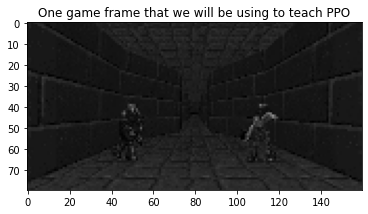

In [10]:
# Displaying evironment for learning 
state = env.reset()
plt.title("One game frame that we will be using to teach PPO")
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB));

In [11]:
env.close()

# 3. Setup Callback

In [12]:
from stable_baselines3.common.callbacks import BaseCallback

class TrainAndLoggingCallback(BaseCallback):
    """
    Callback class that save the model after n steps of iteration
    """
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
    
        return True

In [13]:
CHECKPOINT_DIR = './train/train_deadly_corridor'
LOG_DIR = './logs/log_deadly_corridor'

In [15]:
callback = TrainAndLoggingCallback(check_freq = 200_000, save_path=CHECKPOINT_DIR)

# 4. Training The Model Using Curriculum

In [16]:
# importing PPO algorithm
from stable_baselines3 import PPO

In [23]:
# Useless variable for inicializing PPO
env = VizDoomGym(config=f'github/VizDoom/scenarios/deadly_corridor-s1.cfg')

model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.00003, n_steps=8192, clip_range=.1, gamma=.97, gae_lambda=.9)
# the more complex environment(like Dota or Cs-GO) the higher n_steps, lower learning rate and more iterations

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [22]:
# Curriculum learning
for i in range(1,6):
    env = VizDoomGym(config=f'github/VizDoom/scenarios/deadly_corridor-s{i}.cfg')
    model.set_env(env)
    model.learn(total_timesteps=200_000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_deadly_corridor\PPO_18


KeyboardInterrupt: 

### INFO

ep_len_mean = mean of frames that it takes to end episode\
ep_rew_mean = mean of episode rewards\
approx_kl = diffrence between current policy and previous policy\
clip_fraction = similar to approx_kl\
explained_variance = how our critic is correctly predicting the reward or future


#### to check results using tensorflow dashboard:
 "open cmd"\
 "go to folder"\
 activate\
 cd logs\
 cd PPO_3 "latest PPO"\
 tensorboard --logdir=.\
 "copy given link and paste into browser" (link looks like this http://localhost:6006/)

# 5. Testing The Model

In [ ]:
# Importing eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
# Testing each model 100 times

env = VizDoomGym()

for i in range(10_000, 110_000, 10_000):
    # Reloading best model
    model = PPO.load(f'./train/train_defend_the_center/best_model_{i}')
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)
    print(i, "=", mean_reward)

env.close()

In [ ]:
# Displaying how agent plays the game

model = PPO.load(f'./train/train_deadly_corridor/best_model_200000')
env = VizDoomGym(render=1)

for episode in range(4):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.2)
        total_reward += reward
    
    print(f"Total reward for episode {episode+1} is {total_reward}")
    time.sleep(2)
    
env.close()

In [ ]:
env.close()